## Evaluation of Inter-Flow Detection Models for SD behavior in the NO part

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.lines as mlines
from xgboost import XGBRegressor, XGBClassifier
import shap

In [2]:
# Setting working directory
import json
with open('setup.json', 'r') as openfile:
    setup_object = json.load(openfile)
    WD = setup_object["wd_path"]

In [3]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [8]:
Ms = [5, 10]
COVER_COUNT = 30

The aim of this notebook is to study the applicability of the inter-flow detection methodology, i.e. using information from the O part of overlapping flows to classify the NO part of the target flow. Based on previous analysis and for resource optimization we utilized the first **30** covering flows that overlap completely with the correlation window, i.e. their are **entirely in the correlation window**. This was done in order to provide a more consistent input for the models (covering flows with their observable delays present).

As metrics we evaluate the persence or lack thereof of SD events in the NO part using classification models, while we also study the behavior when predicting the number of SD events, and various characteristics of the longest SD event in the NO part for each flow (namely, the length as well as the relative start and end indices relative to the flow start) using regression models.

Data collected from Monday to Wednesday was used as training data while Thursday and Friday was used for testing. Only those flows were included that last at least until the O/NO split, since for shorter flows we know that there will be no NO part.

Input data (`X`):

- Data coming from the target flow (same features as in the case of INTRA analysis:
    - minimum, maximum, median, mean and standard deviation of delays and jitters in the O part,
    - the delay and jitter values in the O part as individual features,
    - count of SD events in the O part,
    - length and start, end timestamps of the longest SD event in the O part relative to the beginnig of the flow (`bidirectional first seen`),
    - name of the application and application category of the flow,
    - location and connection type (wired or wireless) of the flow,
    - $f_{split\ SD\ ratio}$
- For all covering flow:
    - relative start of the overlapping flow in milliseconds from the beginning of the correlation window (aims to help in placing the covering flow in time)
    - minimum, maximum, median, mean and standard deviation of delays and jitters in the O part
    - the delay and jitter values in the O part as individual features,
    - count of SD events in the O part,
    - length and start, end timestamps of the longest SD event in the O part relative to the beginnig of the flow  (`bidirectional first seen`),
    - $f_{split\ SD\ ratio}$
- Aggregate counter features:
    - count for every application category and application type how many covering flows belong to that category/type
 
For each covering flows scategorical features are not included because one-hot-encoding these would further explode the already large input size, instead the aggreagate counter features are utilized to include similar data for the model.

5 separate models (one for classification, the other for regression problems) were built with distinct target features each:

- the presence or lack thereof of SD events in the NO part as a classification problem,
- the count of SD event in the NO part as a regression problem,
- the length of the longest SD event in the NO part in milliseconds,
- the start timestamp of the longest SD event in the NO part relative to the beginnig of the flow  (`bidirectional first seen`)
- the end timestamp of the longest SD event in the NO part relative to the beginnig of the flow  (`bidirectional first seen`)

The application name, application category name, location and connection type columns are one-hot encoded so that all models can process them. We also made a scaled version of the input sets (`X_scaled`) as the MLP algorithm requires scaled data. For this the `StandardScaler` from the `sklearn.preprocessing` library was used.

The following table shows the input sizes as flow count and feauture count for the train and test sets for each O/NO split value. We sampled the dataset to include 100_000 flows.

The generation of the input and target sets for both training and testing is presented in `create_inter_flow_sets.py`.

In [10]:
df_data_sizes = pd.DataFrame(columns=['Train Set Size', 'Test Set Size', 'Input Feature Count'])
for M in Ms:
    X_train = pd.read_parquet(f'{WD}/train_test/inter/M{M}/X_train.parquet')
    X_test = pd.read_parquet(f'{WD}/train_test/inter/M{M}/X_test.parquet')

    train_size = len(X_train)
    test_size = len(X_test)
    input_feature_count = f"{len(X_train.columns)} features (including "
    for feat in ['application_category_name', 'application_name', 'location', 'connection_type']:
        feat_count = len([col for col in X_train.columns if col.startswith(feat)])
        input_feature_count += f"{feat_count} {feat} "
    input_feature_count += "OH encoded features + "
    for feat in [ 'ov_', 'covering_count']:
        feat_count = len([col for col in X_train.columns if col.startswith(feat)])
        if feat == 'ov_':
            input_feature_count += f"{feat_count / COVER_COUNT:.0f}*{COVER_COUNT}  overlapping and "
        else:
            input_feature_count += f"{feat_count} {feat} "
    input_feature_count += "covering flow related features)"
    input_feature_count = input_feature_count.replace('_', ' ')
    df_data_sizes.loc[M] = [f'{train_size} flows', f'{test_size} flows', input_feature_count]

pd.set_option('max_colwidth', None)
df_data_sizes

,Train Set Size,Test Set Size,Input Feature Count
5,100000 flows,100000 flows,948 features (including 6 application category name 83 application name 9 location 1 connection type OH encoded features + 24*30 overlapping and 106 covering count covering flow related features)
10,100000 flows,100000 flows,1248 features (including 6 application category name 83 application name 9 location 1 connection type OH encoded features + 34*30 overlapping and 96 covering count covering flow related features)


We trained 3 different models for each target: one simple regression model (Logistic Regression for classification and Ridge Regression for the regression tasks), one XGBoost model and a Multi-Layer Perceptron (MLP). These three models were selected to compare the potential for three different approaches. The regression model uses a simple underlying heuristic. The XGBoost is a forest-based model that showed the best results in our testing. It also provides a versatile model and fast training time. The MLP was chosen as a simple artificial neural network.

Grid Search was used to identify the best parameter settings for all models and training was performed with 5-fold cross-validation. To identify the best model for classification the *AUROC* metric was maximized for the Logistic Regression and XGBoost models, while the training loss was minimized as the default configuration for MLP. For Ridge Regression and XGBoost in the case of the regression tasks the *negative mean squared error* metric was optimized. The random states were all set to $42$ to aid reproducability and MLP was run for 1000 iterations. The parameters used for Grid Search for all models are the following:

| **Model Name**                          | **Python Library**       | **Parameters for Grid Search**                                                                                                                                                                                    |
|-----------------------------------------|--------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression                     | `sklearn.linear_model`   | 'solver': ['liblinear', 'lbfgs'],<br>'penalty': ['l1', 'l2'],<br>'C': [0.001, 0.01, 0.1, 1, 10],<br>'max_iter': [1000]                                                                                            |
| Ridge Regression                        | `sklearn.linear_model`   | 'alpha': [0.1, 1, 10]                                                                                                                                                                                             |
| XGBoost Classifier<br>XGBoost Regressor | `xgboost`                | 'n_estimators': [100, 200, 500],<br>'learning_rate': [0.01, 0.1, 0.2],<br>'max_depth': [3, 5, 7]                                                                                                                  |
| MLP Classifier<br>MLP Regressor         | `sklearn.neural_network` | 'hidden_layer_sizes': [(50,), (100,), (50, 50)],<br>'activation': ['tanh', 'relu'],<br>'solver': ['sgd', 'adam'],<br>'alpha': [0.0001, 0.05],<br>'learning_rate': ['constant', 'adaptive'],<br>'max_iter': [1000] |


`inter_flow_models.py` performs the model fitting and evaluation of the best results in the classification and regression tasks.

# Classification

In the classification task the target variable is whether there is a SD event in the NO part of the flow. To compare the predictive power for this metric of different models at the studied O/NO split thresholds we evaluated the performance of the models using the following evaluation metrics:

- Precision (Positive Predictive Value)
- Recall / Sensitivity (True Positive Rate)
- $F_1$-score
- Specificity (True Negative Rate)
- Negative Predictive Value
- Accuracy
- Balance Accuracy

For every O/NO split threhsold (`M`)
the classification metrics are found at `{WD}/inter_results/M{M}/CLASS_metrics.csv`,<br>
best classification parameters are at `{WD}/inter_results/M{M}/CLASS_best params.csv`,<br>
classification results are found at `{WD}/inter_results/M{M}/CLASS_predictions.parquet` (models need to be fitted),<br>
while classification probs are found at `{WD}/inter_results/M{M}/CLASS_probs.parquet` (models need to be fitted).

## Plot results

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


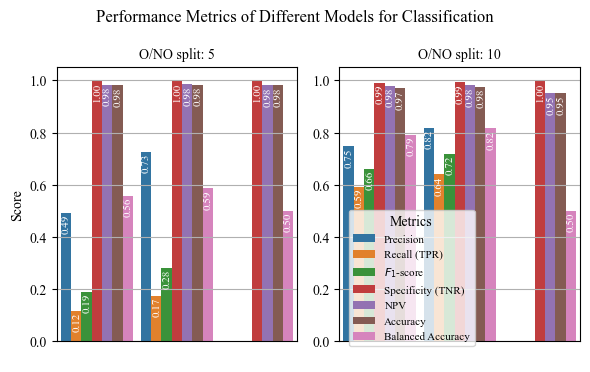

In [32]:
classification_metrics_dfs = []
for M in Ms:
    classification_metrics_df = pd.read_csv(f'{WD}/inter_results/M{M}/CLASS_metrics.csv')
    classification_metrics_df.set_index('Model', inplace=True)
    classification_metrics_df = classification_metrics_df.reindex(classification_metrics_df.columns, axis=1)
    classification_metrics_dfs.append(classification_metrics_df)
    # print(classification_metrics_dfs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.75))

for M, classification_metrics_df, a in zip(Ms, classification_metrics_dfs, ax.flatten()):
    df = classification_metrics_df.reset_index().melt(id_vars='Model').rename(columns=str.title)
    sns.barplot(x='Model', y='Value', hue='Variable', data=df, width=.9, ax=a)
    a.set_xlabel('Model')
    a.set_ylabel('Score')
    a.set_title(f'O/NO split: {M}', fontsize=10)
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
    if M in [5, 10]:
        a.set_xticks([])
        a.set_xlabel('')
    if M in [10]:
        a.set_ylabel('')
    a.legend().set_visible(False)
    a.grid(axis='y')
    for i in a.containers:
        a.bar_label(i, rotation=90, fmt='%.2f', padding=-15, fontsize=8, color='white')

fig.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Metrics', framealpha=.8, loc='center',
           bbox_to_anchor=(.3, .23), fontsize=8)
# Show the plot
plt.savefig('plots/evaluation/INTER_classification_metrics.pdf', bbox_inches='tight')
fig.suptitle('Performance Metrics of Different Models for Classification')
fig.tight_layout()
plt.show()

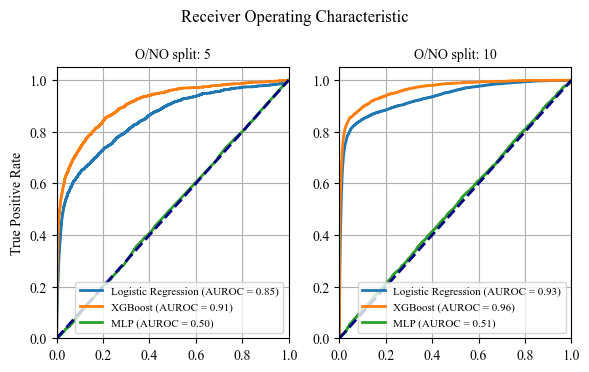

In [41]:
classification_probss = []
y_test_classifiers = []
for M in Ms:
    classification_probss.append(pd.read_parquet(f'{WD}/inter_results/M{M}/CLASS_probs.parquet'))
    y_test_classifiers.append(pd.read_parquet(f'{WD}/train_test/inter/M{M}/y_test_classifier.parquet')['NO_SD_count'])

# Plot ROC curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.75))

for M, classification_probs, y_test_classifier, a in zip(Ms, classification_probss, y_test_classifiers, ax.flatten()):
    for column in classification_probs.columns.to_list():
        proba = classification_probs[column]
        fpr, tpr, _ = roc_curve(y_test_classifier, proba)
        roc_auc = auc(fpr, tpr)
        a.plot(fpr, tpr, lw=2, label=f"{column} (AUROC = {roc_auc:.2f})")
    a.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    a.set_xlim([0.0, 1.0])
    a.set_ylim([0.0, 1.05])
    a.set_xlabel('False Positive Rate')
    a.set_ylabel('True Positive Rate')
    a.set_title(f'O/NO split: {M}', fontsize=10)
    a.legend(loc="lower right", fontsize=8)
    if M in [5, 10]:
        a.set_xlabel('')
    if M in [10]:
        a.set_ylabel('')
    a.grid()
fig.tight_layout()
plt.savefig('plots/evaluation/INTER_ROC_curves.pdf')
fig.suptitle('Receiver Operating Characteristic')
fig.tight_layout()
plt.show()

# Regression

In the regression tasks there are different target variables for each task. The evaluated metrics are the following:

- Mean Absolute Error
- Root Mean Squared Error
- Median Absolute Error
- Mean Absolute Percentage Error
- $R^2$ metric

For every regression task in
- `count` for the count of NO SD events,
- `max_len` for the length of the longest SD event in the NO part,
- `max_start` and `max_end` for the start and end timestamps of the longest SD

the regression metrics are found in `{WD}/inter_results/M{M}/REG_{model_name}_metrics.csv`,
the regression predictions are found in `{WD}/inter_results/M{M}/REG_{model_name}_predictions.parquet` (if models have been fitted).

The best model parameters are fount at `{WD}/inter_results/M{M}/REG_{model_name}_best_params.csv`.

The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more va

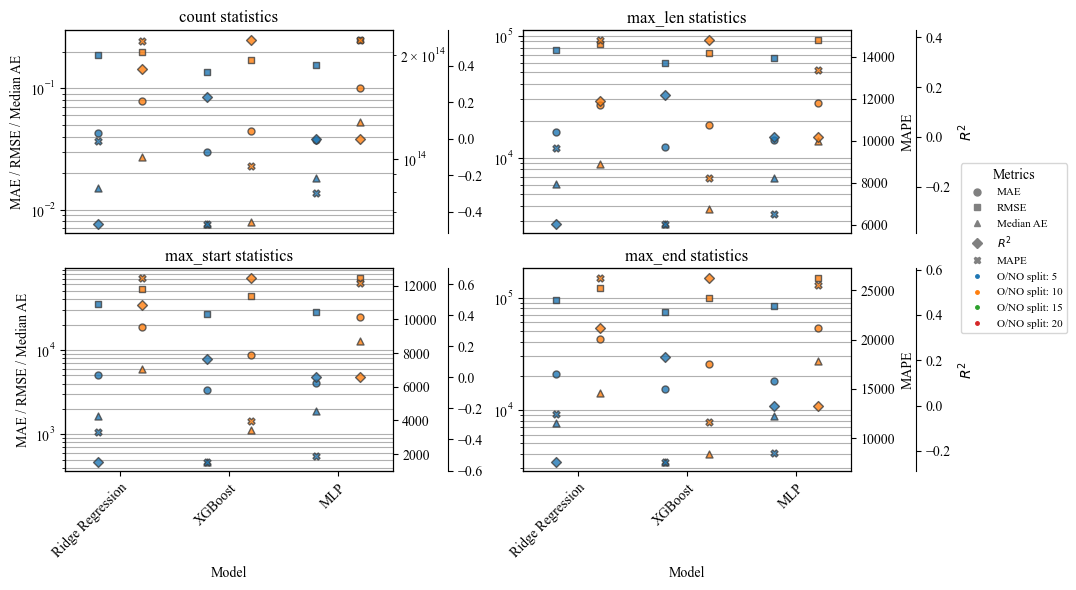

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for reg_name, a in zip(['count', 'max_len', 'max_start', 'max_end'], ax.flatten()):
    dfs = []
    for M in Ms:
        regression_metrics_df = pd.read_csv(f'E:/data/inter_results/M{M}/REG_{reg_name}_metrics.csv')
        df = regression_metrics_df.reset_index().melt(id_vars='Model').rename(columns=str.title)
        df['O/NO split'] = M
        dfs.append(df)
    df_merged = pd.concat(dfs)

    palette1 = sns.color_palette(n_colors=4)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='o', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MAE'], alpha=.8, ax=a)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='s', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'RMSE'], alpha=.8, ax=a)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='^', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MedianAE'], alpha=.8, ax=a)
    
    a2 = a.twinx()
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='X', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MAPE'], alpha=.8, ax=a2)
    a2.set_ylabel('MAPE')
    a2.legend().set_visible(False)
    a3 = a.twinx()
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='D', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == '$R^2$'], alpha=.8, ax=a3)
    a3.set_ylabel('$R^2$')
    a3.legend().set_visible(False)
    if reg_name in ['count', 'max_start']:
        a3.spines.right.set_position(("axes", 1.17))
    else:
        a3.spines.right.set_position(("axes", 1.2))


    a.set_xlabel('Model')
    a.set_ylabel('MAE / RMSE / Median AE')
    a.set_yscale('log')
    if reg_name == 'count':
        a2.set_yscale('log')
    a.set_title(f'{reg_name} statistics')
    if reg_name in ['count', 'max_len']:
        a.set_xticks([])
        a.set_xlabel('')
    if reg_name in ['max_len', 'max_end']:
        a.set_ylabel('')
    else:
        a2.set_ylabel('')
        a3.set_ylabel('')
    a.legend().set_visible(False)
    a.grid(axis='y', which='both')

    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 

# Define custom markers and colors for the legend
legend_elements = [
    mlines.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=5, label='MAE', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='s', linestyle='None', markersize=5, label='RMSE', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='^', linestyle='None', markersize=5, label='Median AE', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='D', linestyle='None', markersize=5, label='$R^2$', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='X', linestyle='None', markersize=5, label='MAPE', linewidth=1),
    mlines.Line2D([], [], color=palette1[0], marker='.', linestyle='None', markersize=5, label='O/NO split: 5'),
    mlines.Line2D([], [], color=palette1[1], marker='.', linestyle='None', markersize=5, label='O/NO split: 10'),
    mlines.Line2D([], [], color=palette1[2], marker='.', linestyle='None', markersize=5, label='O/NO split: 15'),
    mlines.Line2D([], [], color=palette1[3], marker='.', linestyle='None', markersize=5, label='O/NO split: 20')
]

fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
# Add the custom legend to the plot
plt.legend(handles=legend_elements, title='Metrics', framealpha=.8, loc='center',
           bbox_to_anchor=(1.5, 1.1), fontsize=8)
# plt.savefig('plots/evaluation/INTER_regression_metrics.pdf', bbox_inches='tight')
plt.show()

Since the measured regression metrics may get influenced by the class imbalance, in this case flows without SD events in the NO are the majority class, it is useful to plot the results for the minority class (here flows that have SD events in the NO part). If the metrics are similar, that means that the models have a similar performance on all flows. However, as we see, these metrics are much worse, which indicates that the regression metrics are esentially good to replicate the performance of the classification model, i.e. they are able to identify when a flow does not have NO SD events, but when they predict that a flow has such an event, the prediction results are unreliable with relatively high errors.

The code that calculates these heuristics can be found in `create_with_SD_REG_metrics.py`.

The metrics for these models can be found at `{WD}/inter_results/M{M}/REG_{model_name}_metrics_with_SD.csv`.

The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
The palette list has more values (4) than needed (2), which may not be intended.
set_ticklabels() should only

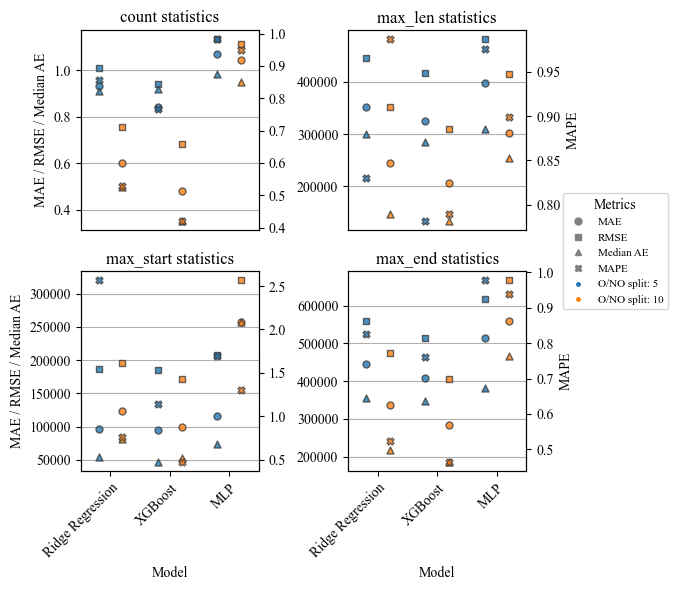

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

for reg_name, a in zip(['count', 'max_len', 'max_start', 'max_end'], ax.flatten()):
    dfs = []
    for M in Ms:
        regression_metrics_df = pd.read_csv(f'E:/data/inter_results/M{M}/REG_{reg_name}_metrics_with_SD.csv')
        df = regression_metrics_df.reset_index().melt(id_vars='Model').rename(columns=str.title)
        df['O/NO split'] = M
        dfs.append(df)
    df_merged = pd.concat(dfs)

    palette1 = sns.color_palette(n_colors=4)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='o', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MAE'], alpha=.8, ax=a)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='s', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'RMSE'], alpha=.8, ax=a)
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='^', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MedianAE'], alpha=.8, ax=a)
    
    a2 = a.twinx()
    sns.stripplot(x='Model', y='Value', hue='O/NO split', dodge=True, marker='X', palette=palette1, linewidth=1,
                  data=df_merged[df_merged['Variable'] == 'MAPE'], alpha=.8, ax=a2)
    a2.set_ylabel('MAPE')
    a2.legend().set_visible(False)

    a.set_xlabel('Model')
    a.set_ylabel('MAE / RMSE / Median AE')
    a.set_title(f'{reg_name} statistics')
    if reg_name in ['count', 'max_len']:
        a.set_xticks([])
        a.set_xlabel('')
    if reg_name in ['max_len', 'max_end']:
        a.set_ylabel('')
    else:
        a2.set_ylabel('')
    a.legend().set_visible(False)
    a.grid(axis='y', which='both')

    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 

# Define custom markers and colors for the legend
legend_elements = [
    mlines.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=5, label='MAE', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='s', linestyle='None', markersize=5, label='RMSE', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='^', linestyle='None', markersize=5, label='Median AE', linewidth=1),
    # mlines.Line2D([], [], color='grey', marker='D', linestyle='None', markersize=5, label='$R^2$', linewidth=1),
    mlines.Line2D([], [], color='grey', marker='X', linestyle='None', markersize=5, label='MAPE', linewidth=1),
    mlines.Line2D([], [], color=palette1[0], marker='.', linestyle='None', markersize=5, label='O/NO split: 5'),
    mlines.Line2D([], [], color=palette1[1], marker='.', linestyle='None', markersize=5, label='O/NO split: 10')
]

fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
# Add the custom legend to the plot
plt.legend(handles=legend_elements, title='Metrics', framealpha=.8, loc='center',
           bbox_to_anchor=(1.5, 1.1), fontsize=8)
plt.savefig('plots/evaluation/INTER_regression_metrics_with_SD.pdf', bbox_inches='tight')
plt.show()

# Model Interpretation

Here we create the Shapley Summary plot for the interpretation of the model. Only the classification model is interpreted, as the none of the regression models in any of the regression tasks a balanced satisfactory result.

The best classification model was XGBoost at O/NO split threshold 10 in the balance of classification power and minimal resource utilization.

In [55]:
M = 10

In [56]:
class_params = pd.read_csv(f'{WD}/inter_results/M{M}/CLASS_best_params.csv')
class_params = json.loads(class_params[class_params['model'] == 'XGBoost']['parameters'].iloc[0].replace("'", '"'))

In [57]:
class_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [59]:
X_train = pd.read_parquet(f'{WD}/train_test/inter/M{M}/X_train.parquet')
y_train_classifier = pd.read_parquet(f'{WD}/train_test/inter/M{M}/y_train_classifier.parquet')['NO_SD_count']

In [60]:
clf = XGBClassifier(**class_params)
clf.fit(X_train, y_train_classifier)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

[20:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


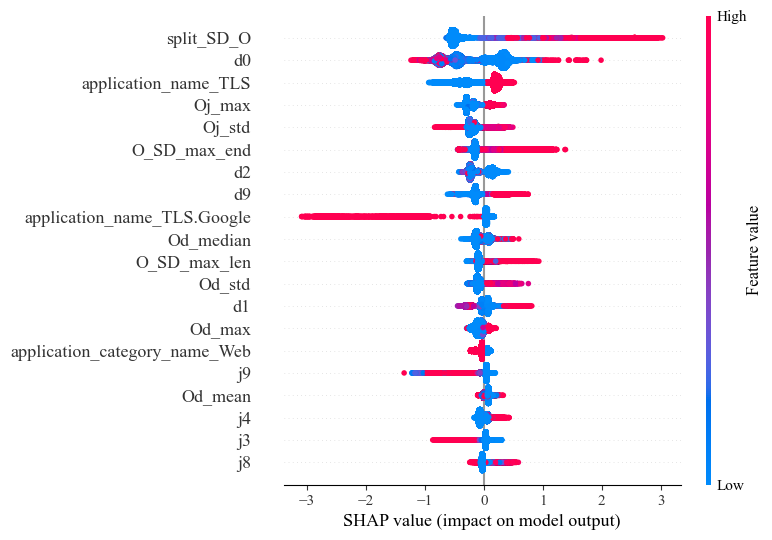

In [61]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_train)
# Plot summary plot
fig = shap.summary_plot(shap_values, X_train, plot_size=.2, show=False)
plt.savefig('plots/evaluation/INTER_class_SHAP.pdf')
plt.show()

These are mostly the same SHAP values in almost the same order as in the case of INTRA flow analysis. Notably, no covering flow related features were elected among the most influential model features during training. This highlights the fact that many the INTRA prediction methodology is already capable of predicting the presence of SD events in the NO part of the flow. However, with the split_SD_O feature being the most prominent of all, this suggests that the model is best at predicting whether a split SD event will continue into the NO part and may not perform as well on SD events that are later in the flow.